In [1]:
Sys.setenv(LANG="en_US.UTF-8")
Sys.setenv(LC_ALL="en_US.UTF-8")

In [2]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(dplyr))

In [3]:
data <- readRDS(file = "./updated_seurat_clustering/Placenta_seuratobj_merged_final_2021.rds")

data

table(Idents(data))

An object of class Seurat 
30426 features across 101031 samples within 2 assays 
Active assay: integrated (4311 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap


              dMSC               vTSC               vVEC                vDC 
               518                697               1105                720 
              dVEC                vFB                vEB               dLEC 
              1660                811               1167               2797 
               dDC               vHBC         vtropho_15               dEpC 
               177               2246               1158               7065 
              dEVT              dFB_1              dFB_2       dGranulocyte 
               135                214                264                357 
dLEC_dysfunctional     dMAC_activated     dMAC_classical          dMonocyte 
                52               2985               6591                248 
             dNK_1              dNK_2           dNK_prol        dPlasmaCell 
              6631               2761                462                551 
             DSC_1              DSC_2               dSCT               dSMC

In [4]:
#Subset vHBC & vDC (antigen presenting macrophages or PAMM) from villi: 

subset = c("vHBC", "vDC")

seurat_mac = subset(data, idents = subset) 

#seurat_obj_receiver = SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["group"]])
table(Idents(seurat_mac))

An object of class Seurat 
30426 features across 2966 samples within 2 assays 
Active assay: integrated (4311 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap


 vDC vHBC 
 720 2246 

In [5]:
DefaultAssay(seurat_mac) <- "RNA"

#Recompute HVG for the subset: 
seurat_mac <- FindVariableFeatures(seurat_mac, selection.method = "vst")

seurat_mac@assays$RNA

Assay data with 26115 features for 2966 cells
Top 10 variable features:
 TENM3, PAPPA2, PAPPA, ADAM12, CYP19A1, SEMA6D, CXCL10, ANKH, FN1, FBN2 

In [6]:
hvg_features = VariableFeatures(object = seurat_mac)

head(hvg_features)

[1] "TENM3"   "PAPPA2"  "PAPPA"   "ADAM12"  "CYP19A1" "SEMA6D"

In [7]:
DefaultAssay(seurat_mac) <- "integrated"

#Rescale the data: 
seurat_mac <- ScaleData(seurat_mac, features= hvg_features)

seurat_mac <- RunPCA(seurat_mac, verbose = FALSE, features= hvg_features)

Centering and scaling data matrix



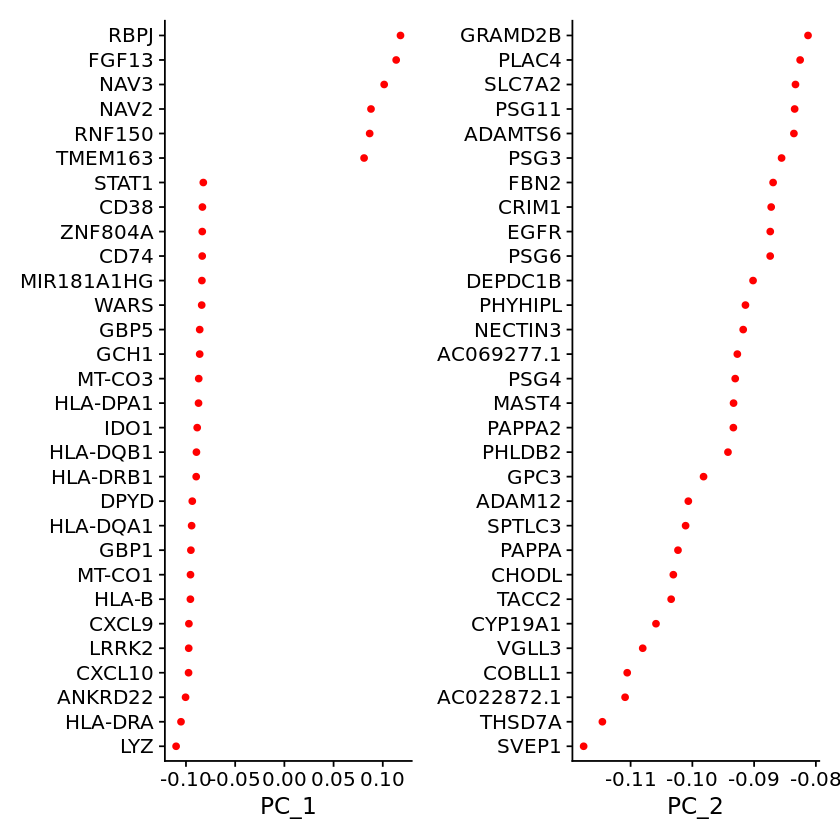

In [9]:
VizDimLoadings(object = seurat_mac, dims= 1:2, col= "red") 

#RBPJ, FGF13 are prominent HBC markers. 

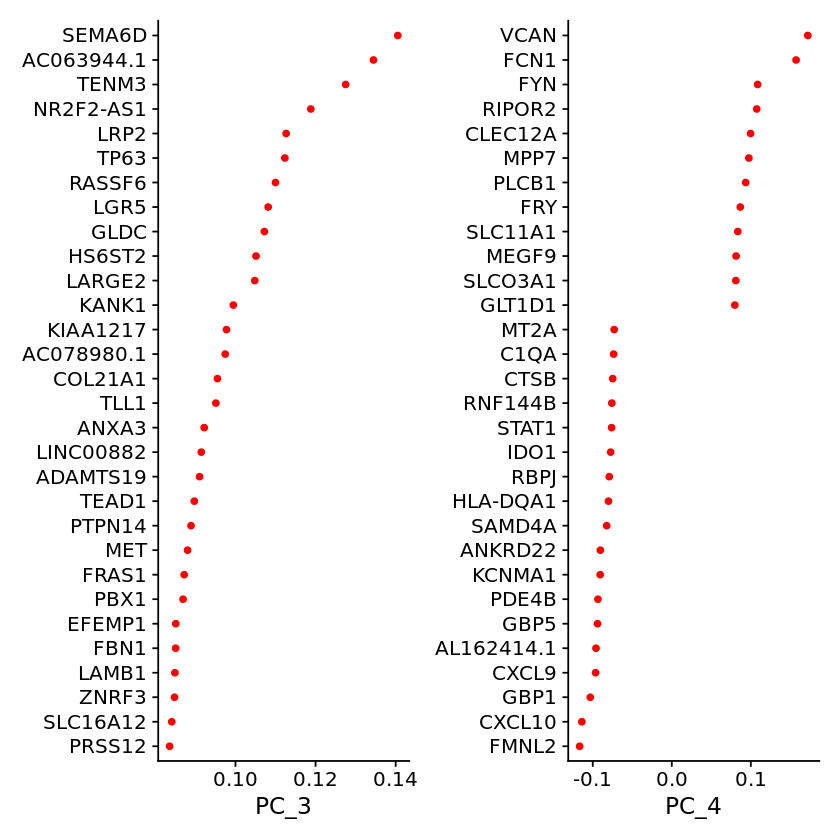

In [10]:
VizDimLoadings(object = seurat_mac, dims= 3:4, col= "red")

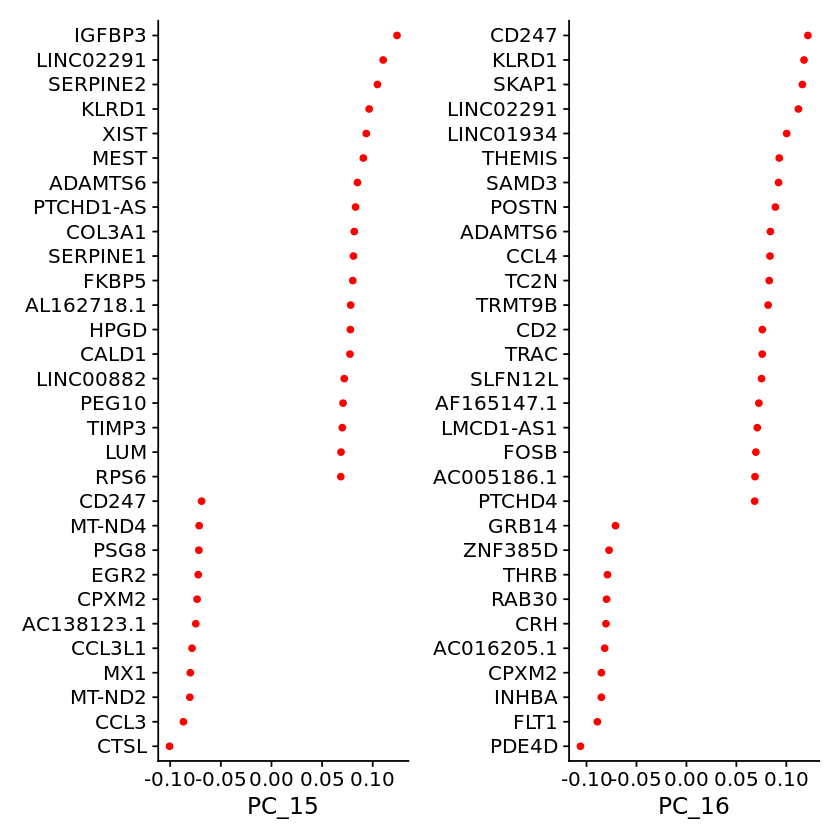

In [22]:
VizDimLoadings(object = seurat_mac, dims= 15:16, col= "red")

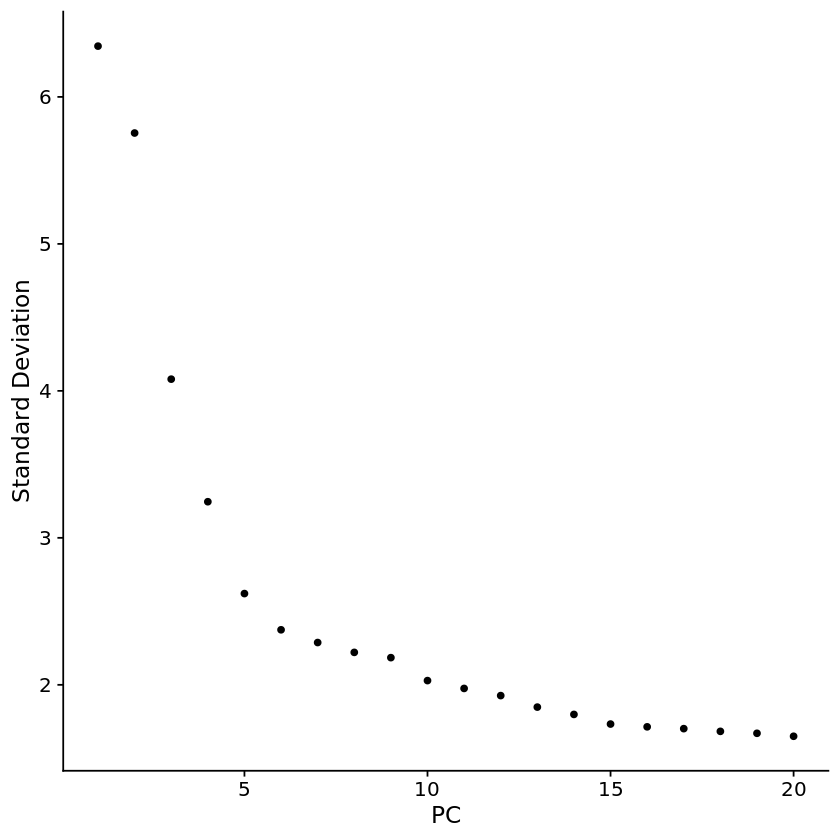

In [11]:
ElbowPlot(seurat_mac)

In [23]:
#Continue with PC: 
seurat_mac <- FindNeighbors(seurat_mac, dims = 1:14, force.recalc = T)

seurat_mac <- FindClusters(seurat_mac, resolution = 0.5, algorithm=2)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2966
Number of edges: 104416

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8244
Number of communities: 11
Elapsed time: 0 seconds


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2966
Number of edges: 104416

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9031
Number of communities: 6
Elapsed time: 0 seconds


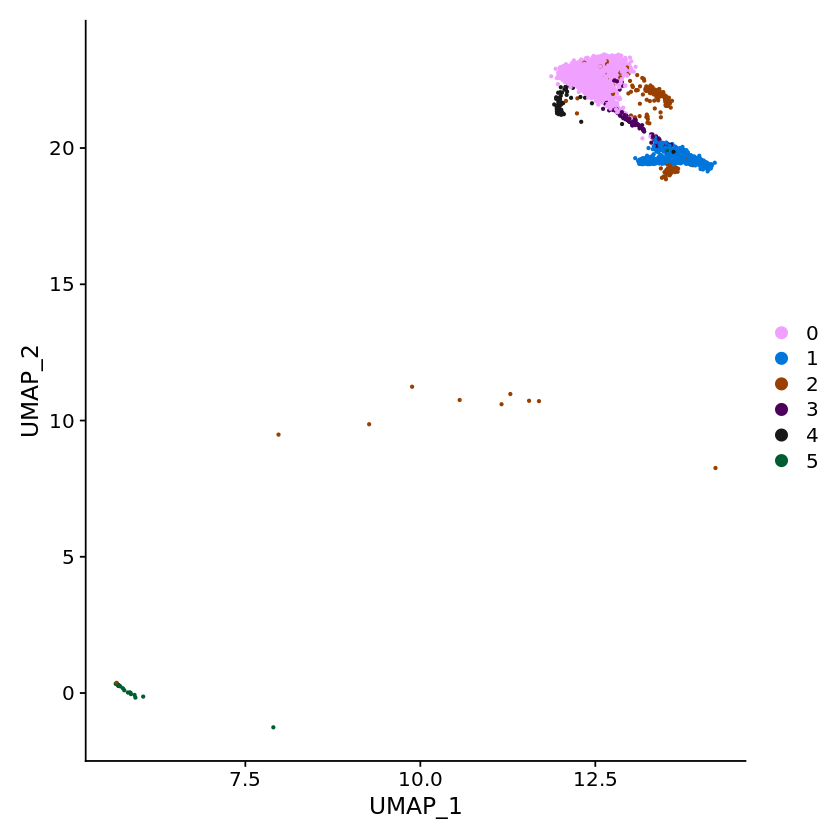

In [26]:
seurat_mac <- FindClusters(seurat_mac, resolution = 0.2, algorithm=2)

UMAPPlot(object= seurat_mac, cols= "alphabet")

In [34]:
table(Idents(seurat_mac))


   0    1    2    3    4    5 
1867  623  204  176   70   26 

In [33]:
pdf("./vHBC_subclustering/vHBC_subclustering_v1_1103.pdf", w=5,h=5, paper= 'special')

UMAPPlot(object= seurat_mac, cols= "alphabet")

dev.off()

png 
  2

In [28]:
#Create another object & recalculate cluster at low resolution.
#Increasing resolution > 0.2 gives rise to non-specific clusters (an example is above)
seurat_hbc <- FindClusters(seurat_mac, resolution = 0.2, algorithm=2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2966
Number of edges: 104416

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9031
Number of communities: 6
Elapsed time: 0 seconds


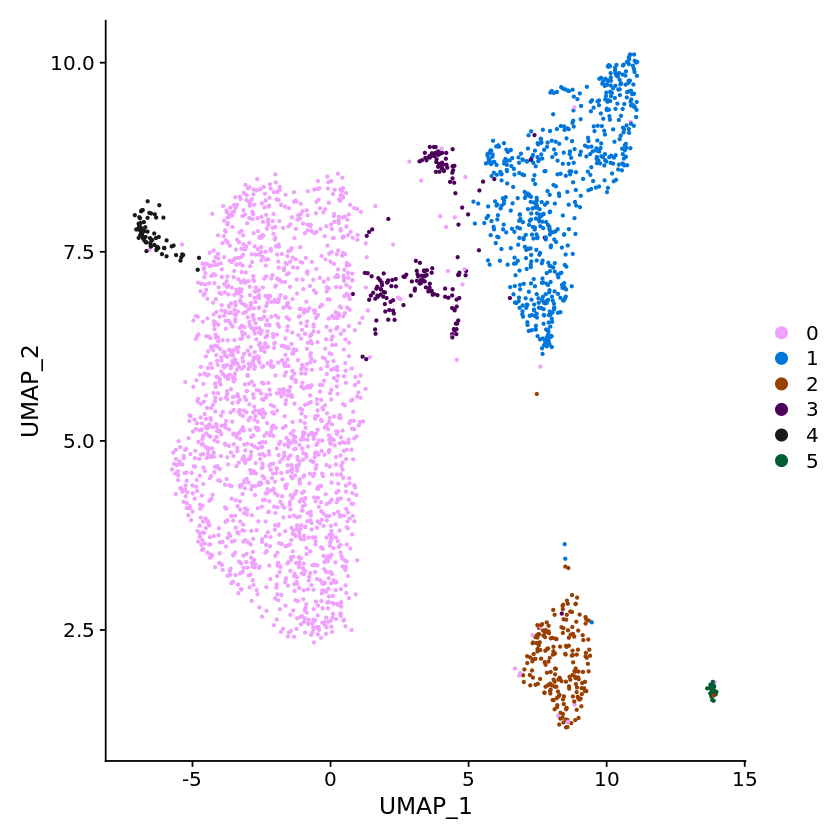

In [29]:
seurat_hbc <- RunUMAP(seurat_hbc, reduction = "pca", dims = 1:14, umap.method = "umap-learn")

UMAPPlot(object= seurat_hbc, cols= "alphabet") #Subclustering for internal use. 

In [55]:
pdf("./vHBC_subclustering/vHBC_subclustering_v2_recalcUMAP_1103.pdf", w=5,h=5, paper= 'special')

UMAPPlot(object= seurat_hbc, cols= "alphabet")

dev.off()

png 
  2

In [36]:
DefaultAssay(seurat_hbc) <- "RNA"

all.markers= FindAllMarkers(seurat_hbc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, test.use= "LR")

head(all.markers)

write.csv(all.markers, file= "./vHBC_subclustering/vHBC_subclustering_markers_LR_lowResolution.csv")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
F13A1,0.000000e+00,1.638930,0.976,0.416,0.000000e+00,0,F13A1
RBPJ,0.000000e+00,1.429368,0.988,0.614,0.000000e+00,0,RBPJ
SLC9A9,1.028972e-308,1.265678,0.971,0.561,2.687160e-304,0,SLC9A9
FGF13,1.860039e-280,1.518107,0.887,0.295,4.857491e-276,0,FGF13
MTSS1,9.946487e-235,1.313948,0.901,0.424,2.597525e-230,0,MTSS1
NAV3,2.901011e-202,1.437726,0.753,0.221,7.575991e-198,0,NAV3


In [40]:
DefaultAssay(seurat_hbc) <- "RNA"

all.markers= FindAllMarkers(seurat_hbc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, test.use= "negbinom")

head(all.markers)

write.csv(all.markers, file= "./vHBC_subclustering/vHBC_subclustering_markers_NegBinom_lowResolution.csv")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Calculating cluster 5

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
F13A1,6.994728e-154,1.1348365,0.976,0.416,1.826673e-149,0,F13A1
MTSS1,5.527746e-132,0.7850320,0.901,0.424,1.443571e-127,0,MTSS1
SLC9A9,1.915062e-130,0.8087032,0.971,0.561,5.001186e-126,0,SLC9A9
RBPJ,4.630780e-124,1.0054088,0.988,0.614,1.209328e-119,0,RBPJ
PLTP,4.500813e-122,0.6917543,0.648,0.179,1.175387e-117,0,PLTP
FGF13,1.059645e-114,0.9237951,0.887,0.295,2.767262e-110,0,FGF13


In [38]:
seurat_hbc

An object of class Seurat 
30426 features across 2966 samples within 2 assays 
Active assay: RNA (26115 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

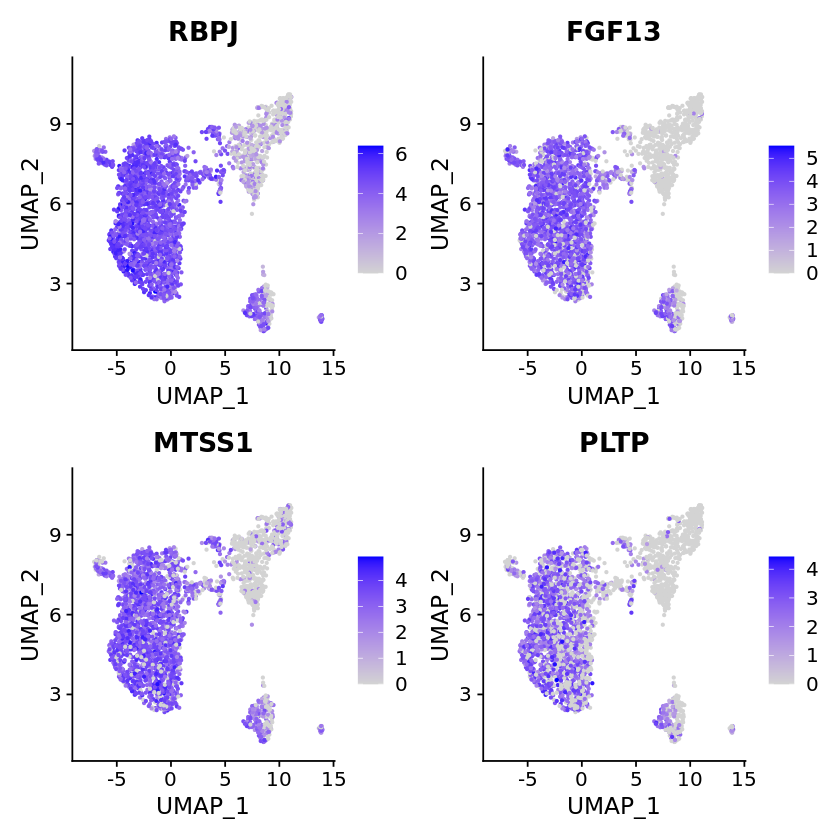

In [37]:
#FeaturePlot(object = seurat_hbc, features = c("PSG4", "RASA1", "NECTIN3", "PSG4"))

#FeaturePlot(object = seurat_hbc, features = c("PSG3", "PSG5", "MMP11", "CYP19A1"))

#FeaturePlot(object = seurat_hbc, features = c("F13A1", "PAPPA", "PAPPA2", "CHODL"))

#FeaturePlot(object = seurat_hbc, features = c("MSR1", "FOS", "CD36", "LYVE1"))

#FeaturePlot(object = seurat_hbc, features = c("CD163", "CD163L1", "CD86", "CD83"))

#Plot some prominent markers: 
FeaturePlot(object = seurat_hbc, features = c("RBPJ", "FGF13", "MTSS1", "PLTP"))

In [45]:
seurat_hbc

An object of class Seurat 
30426 features across 2966 samples within 2 assays 
Active assay: RNA (26115 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

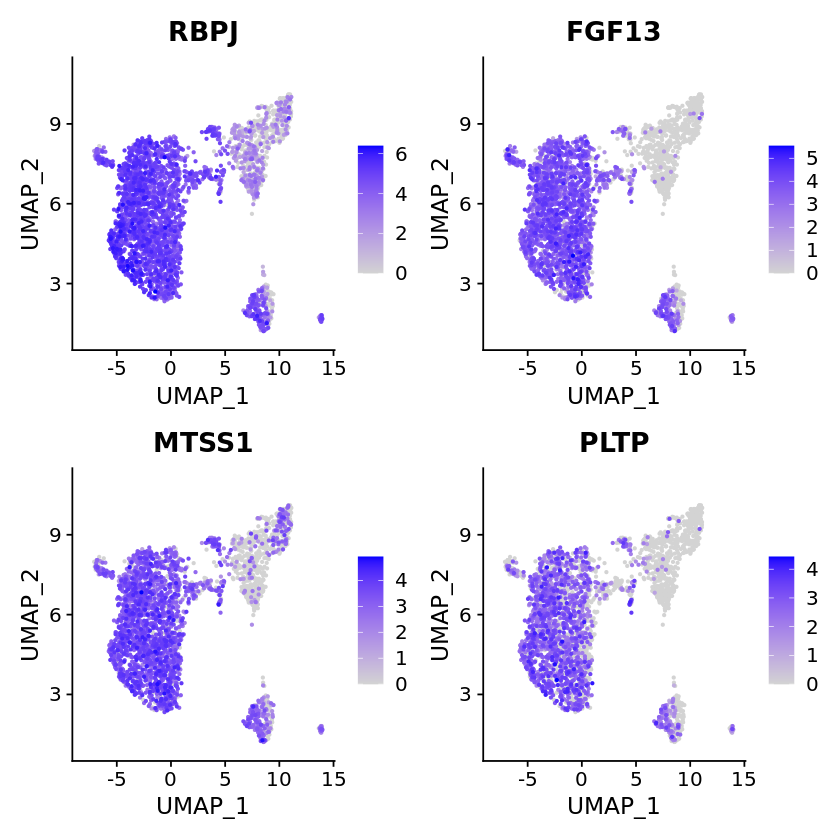

In [41]:
FeaturePlot(object = seurat_hbc, features = c("RBPJ", "FGF13", "MTSS1", "PLTP"), order=TRUE)

In [51]:
features= c("RBPJ", "FGF13", "MTSS1", "PLTP", "MSR1", "FOS", "CD36", "LYVE1",
            "CD74", "SRGN", "IFI44L", "STAT1", "FTL", "LY96", "SPP1",
            "FCGRT", "STAB1", "CSF1R", "ADAP2", "CD163", "CD163L1", "CD86", "CD83", 
            "F13A1", "PAPPA", "PAPPA2", "CHODL","PSG3", "PSG5", "MMP11", "CYP19A1", 
            "PSG4", "RASA1", "NECTIN3")

In [52]:
DefaultAssay(seurat_hbc) <- "RNA"

In [53]:
pdf("./vHBC_subclustering/vHBC_subclustering_markers01_1103.pdf", w=9,h=33, paper= 'special')

FeaturePlot(object = seurat_hbc, features = features, order=TRUE, ncol=3)

dev.off() 

png 
  2

In [49]:
seurat_mac

An object of class Seurat 
30426 features across 2966 samples within 2 assays 
Active assay: integrated (4311 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [54]:
#Plot the same markers on the original UMAP:
DefaultAssay(seurat_mac) <- "RNA"

pdf("./vHBC_subclustering/vHBC_subclustering_markers01_1103_mainUMAP.pdf", w=9,h=33, paper= 'special')

FeaturePlot(object = seurat_mac, features = features, order=TRUE, ncol=3)

dev.off() 

png 
  2

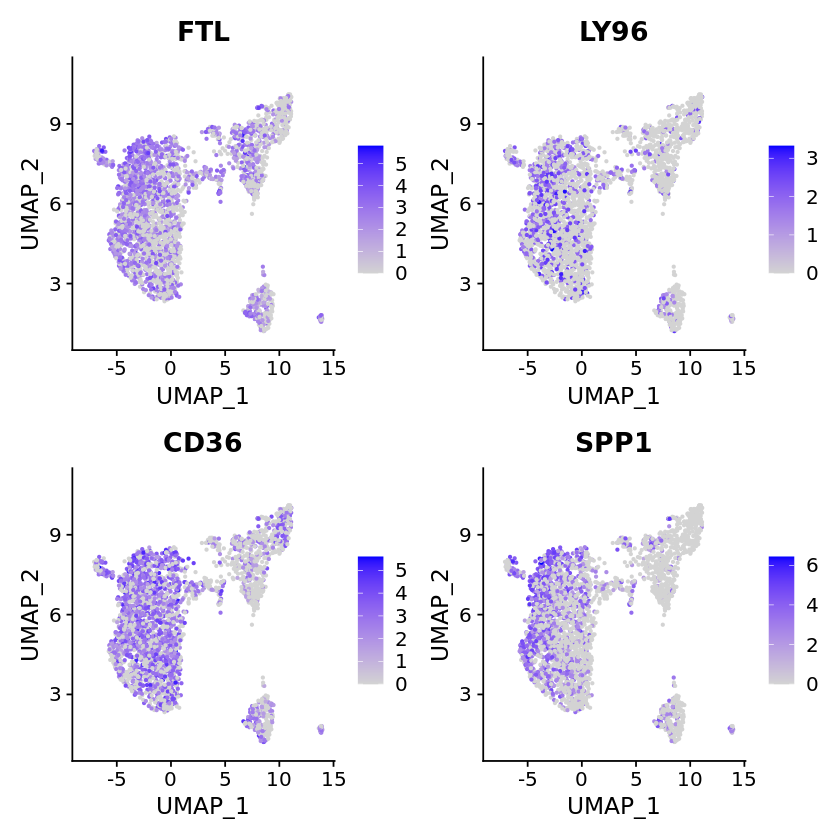

In [56]:
FeaturePlot(object = seurat_hbc, features = c("FTL", "LY96", "CD36", "SPP1"))

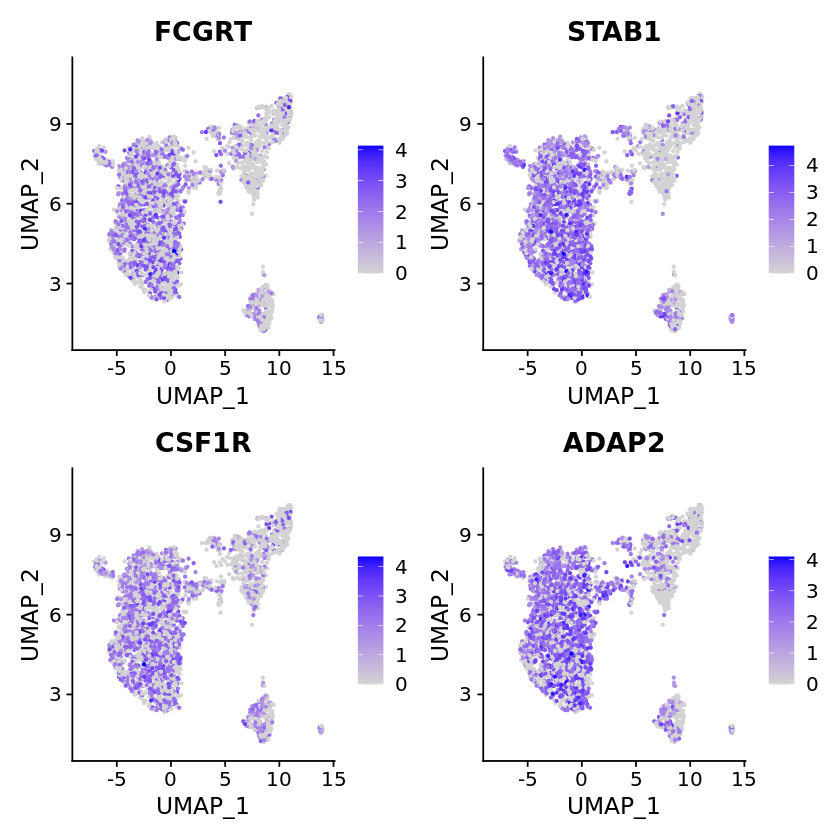

In [57]:
FeaturePlot(object = seurat_hbc, features = c("FCGRT", "STAB1", "CSF1R", "ADAP2"))

In [64]:
pdf("./vHBC_subclustering/vHBC_subclustering_markers01_1103_mainUMAP.pdf", w=9,h=33, paper= 'special')

FeaturePlot(object = seurat_mac, features = features, order=TRUE, ncol=3)

dev.off() 

png 
  2

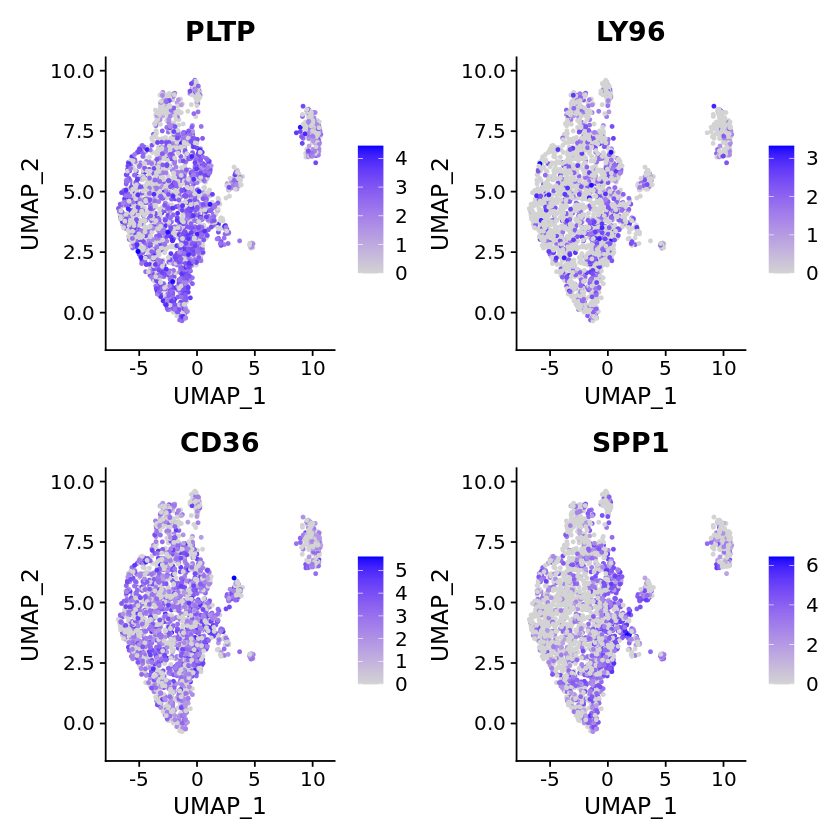

In [63]:
FeaturePlot(object = seurat_hbc, features = c("PLTP", "LY96", "CD36", "SPP1"))

In [59]:
table(Idents(seurat_hbc)) #Cell numbers per group. 


   0    1    2    3    4    5 
1867  623  204  176   70   26 

In [60]:
table(Idents(seurat_mac)) #Cell numbers per group. 


   0    1    2    3    4    5 
1867  623  204  176   70   26 

In [61]:
saveRDS(seurat_hbc, file= "./vHBC_subclustering/vHBC_DC_subclustering_1103.rds")

In [3]:
#Read the HBC subcluster data:
data <- readRDS(file = "./vHBC_subclustering/vHBC_DC_subclustering_1103.rds")

data

An object of class Seurat 
30426 features across 2966 samples within 2 assays 
Active assay: RNA (26115 features)
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

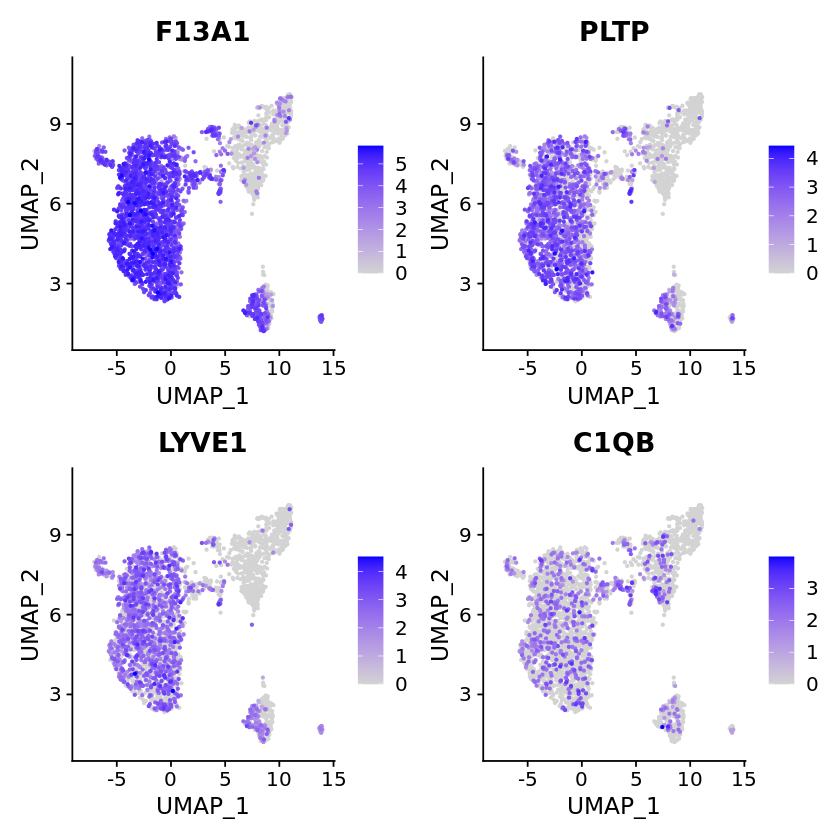

In [5]:
#Plot: LYVE1+MΦ1 genes: 
FeaturePlot(object = data, features = c("F13A1", "PLTP", "LYVE1", "C1QB"), order=TRUE)

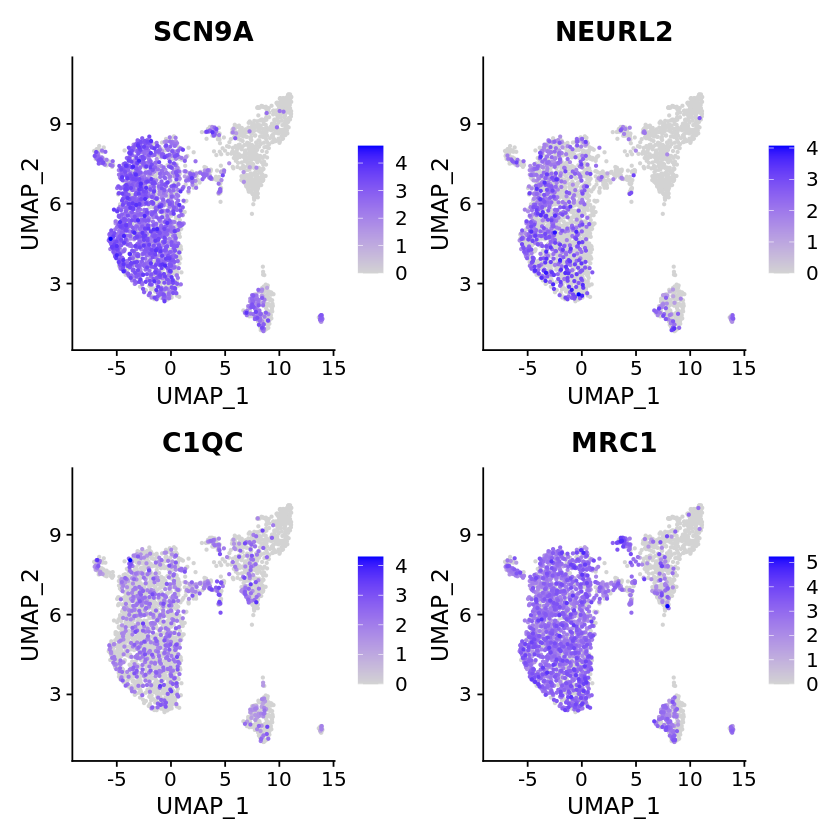

In [6]:
FeaturePlot(object = data, features = c("SCN9A", "NEURL2", "C1QC", "MRC1"), order=TRUE)

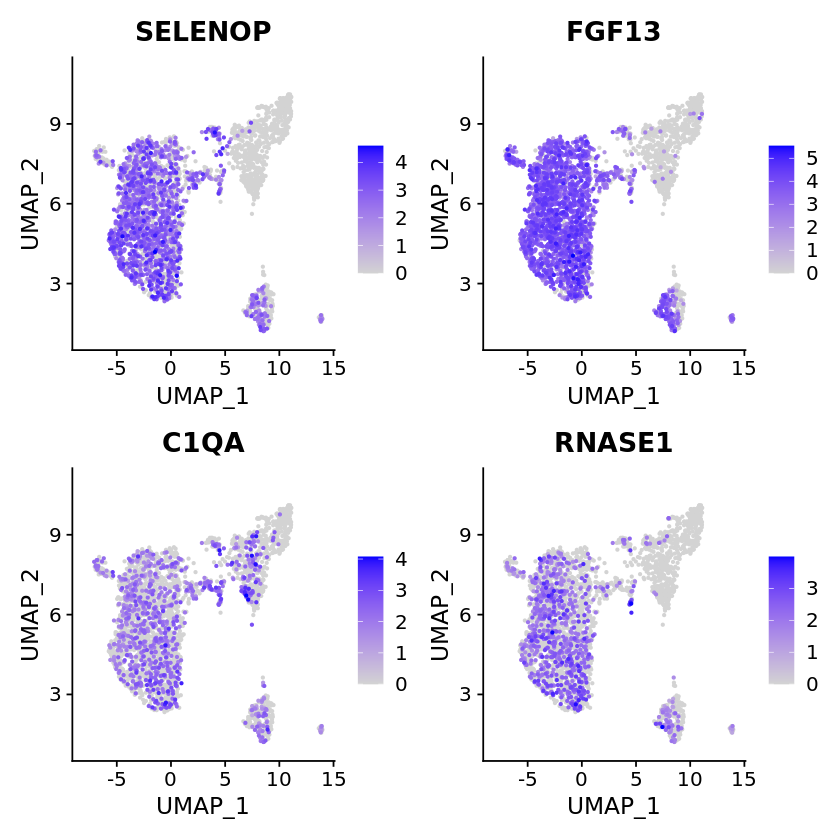

In [8]:
FeaturePlot(object = data, features = c("SELENOP", "FGF13", "C1QA", "RNASE1"), order=TRUE)

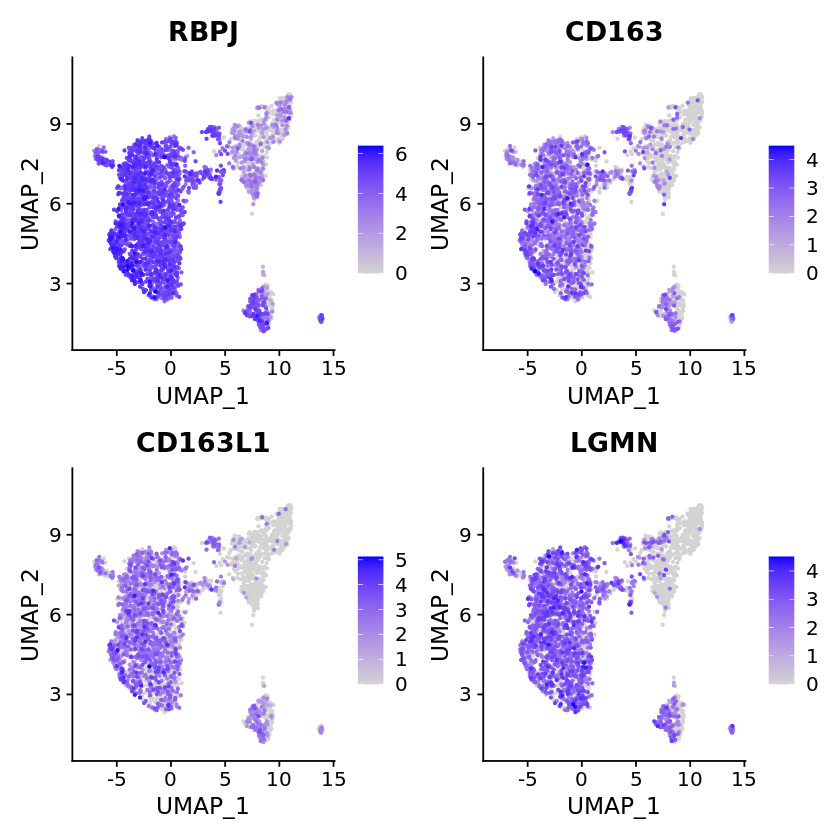

In [9]:
FeaturePlot(object = data, features = c("RBPJ", "CD163", "CD163L1", "LGMN"), order=TRUE)

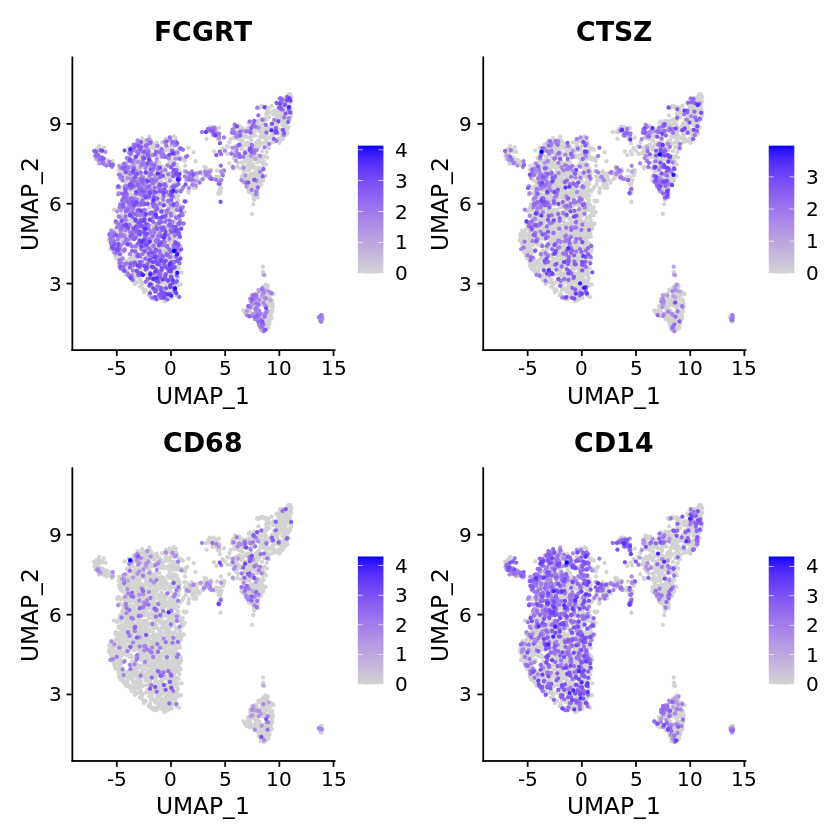

In [31]:
#DOCK4+MΦ2:
#FeaturePlot(object = data, features = c("SLC16A10", "FSIP1", "DOCK4", "PPARD"), order=TRUE)
#FeaturePlot(object = data, features = c("FAM129B", "CTSL", "SIPA1L1", "IL1RAP"), order=TRUE)

#FeaturePlot(object = data, features = c("CCL13", "CCL18", "RNASE1", "FTL"), order=TRUE): 
#FeaturePlot(object = data, features = c("CCL13", "CCL18", "RNASE1", "FTL"), order=TRUE)
#FeaturePlot(object = data, features = c("NUPR1", "CD209", "DAB2", "FOLR2"), order=TRUE)
#FeaturePlot(object = data, features = c("GATM", "LGMN", "CST3", "VSIG4"), order=TRUE)
FeaturePlot(object = data, features = c("FCGRT", "CTSZ", "CD68", "CD14"), order=TRUE)

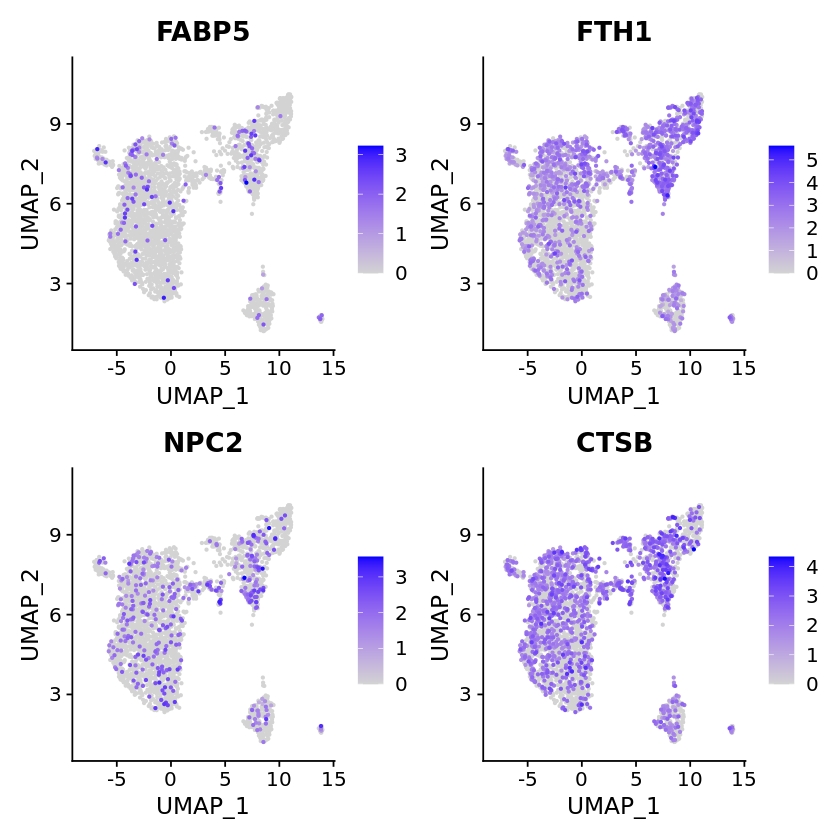

In [33]:
#FeaturePlot(object = data, features = c("LYVE1", "FSCN1", "PLTP", "MS4A4A"), order=TRUE)

#MΦ_AgP:
FeaturePlot(object = data, features = c("FABP5", "FTH1", "NPC2", "CTSB"), order=TRUE)

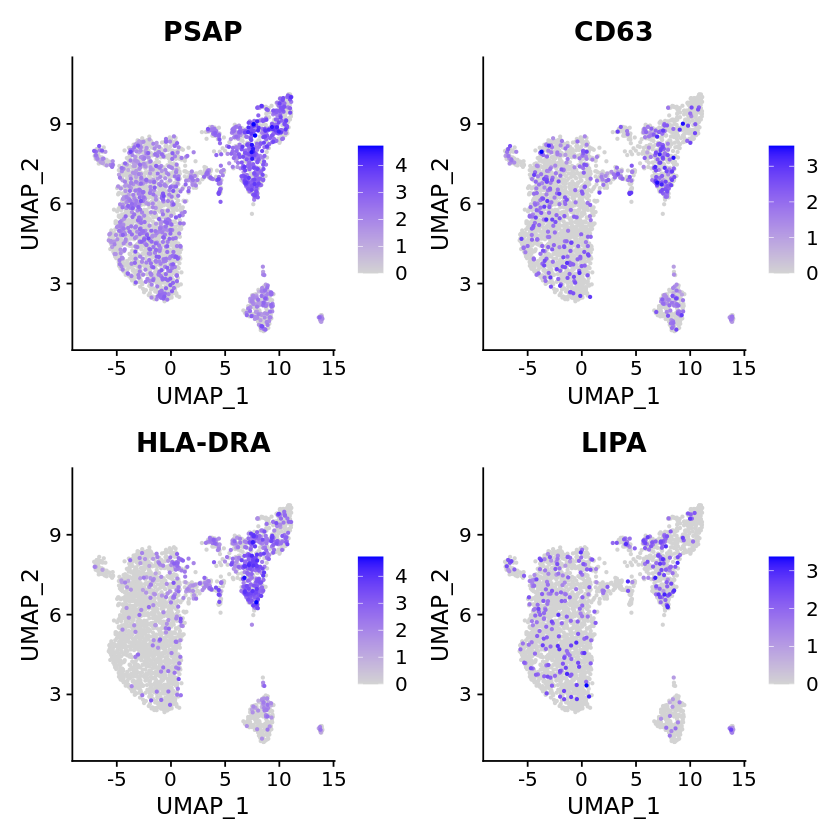

In [35]:
FeaturePlot(object = data, features = c("PSAP", "CD63", "HLA-DRA", "LIPA"), order=TRUE)

In [39]:
#FeaturePlot(object = data, features = c("VIM", "ANXA5", "S100A11", "GRN"), order=TRUE)

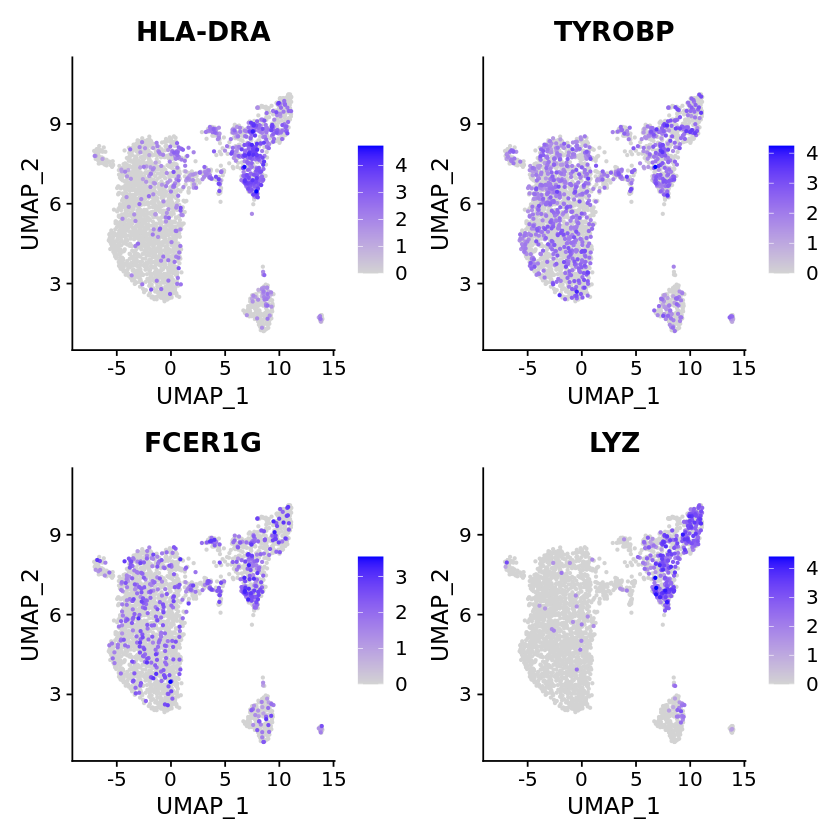

In [43]:
FeaturePlot(object = data, features = c("HLA-DRA", "TYROBP", "FCER1G", "LYZ"), order=TRUE)

In [62]:
#https://stats.stackexchange.com/questions/323968/theta-going-towards-infinity-in-negative-binomial-model

In [64]:
DefaultAssay(seurat_hbc_new) <- "RNA"

all.markers= FindAllMarkers(seurat_hbc_new, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, test.use= "negbinom")

head(all.markers)

write.csv(all.markers, file= "vHBC_subclustering_markers_NegBinom_midResolution.csv")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Calculating cluster 5

Calculating cluster 6

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit r

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, m

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SPP1,9.028759e-25,0.8146926,0.618,0.400,2.357860e-20,0,SPP1
SLC9A9,9.801195e-22,0.2849133,0.979,0.949,2.559582e-17,0,SLC9A9
AC074327.1,4.264727e-20,0.4026139,0.429,0.209,1.113734e-15,0,AC074327.1
F13A1,8.018000e-20,0.3055848,0.988,0.965,2.093901e-15,0,F13A1
RBPJ,5.367028e-15,0.2828070,0.995,0.976,1.401599e-10,0,RBPJ
CD36,2.141341e-14,0.3935256,0.743,0.607,5.592111e-10,0,CD36
